In [156]:
import pandas as pd
import sqlalchemy as sa

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

import numpy as np

import json

### Interarrival Times

In [2]:
engine = sa.create_engine(open("SQL_queries/engine.txt", 'r').read())

In [3]:
with engine.connect() as conn:
    tno_historical_admissions_df = pd.read_sql(open("SQL_queries\\tno_historical_admissions_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date

tno_historical_admissions_df

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\1902730316.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_historical_admissions_df = pd.read_sql(open("SQL_queries\\tno_historical_admissions_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date


,SpellStartDate,em_el_dc,N
0,2022-01-02,EMERG,1
1,2022-01-03,EMERG,5
2,2022-01-04,EMERG,2
3,2022-01-05,EMERG,3
4,2022-01-06,EMERG,1
...,...,...,...
2923,2025-07-25,EMERG,6
2924,2025-07-25,ELECT,3
2925,2025-07-26,EMERG,3
2926,2025-07-27,EMERG,2


In [4]:
tno_historical_admissions_df.isna().sum()

SpellStartDate     0
em_el_dc          70
N                  0
dtype: int64

In [5]:
tno_historical_admissions_df["em_el_dc"].value_counts()

em_el_dc
EMERG    1253
ELECT     858
DCASE     747
Name: count, dtype: int64

In [6]:
tno_historical_admissions_df["em_el_dc"] = tno_historical_admissions_df["em_el_dc"].fillna("EMERG")

In [7]:
tno_historical_admissions_df["SpellStartDate"] = pd.to_datetime(tno_historical_admissions_df["SpellStartDate"])

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


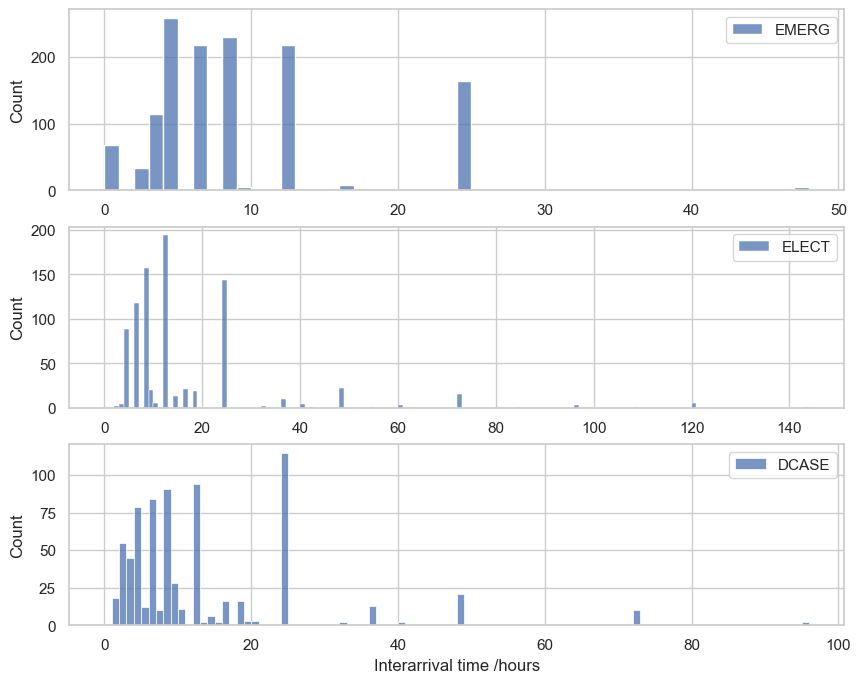

In [8]:
iat_dict = {}

fig, ax = plt.subplots(3,1)

fig.set_figheight(8)
fig.set_figwidth(10)

for a, urgency in zip(ax, tno_historical_admissions_df["em_el_dc"].unique()):
    tmp_df = tno_historical_admissions_df.query(f'em_el_dc == "{urgency}"')
    iats = ((tmp_df["SpellStartDate"].diff() / pd.Timedelta(hours=1)) / tmp_df["N"])
    iat_dict[urgency] = np.histogram(iats, bins=range(int(iats.max()+1)), density=True)
    # iats.plot.hist(bins=range(int(iats.max()+1)), label=urgency, ax=a)

    sns.histplot(iats, ax=a, label=urgency, bins=range(int(iats.max()+1)))
    plt.xlabel("Interarrival time /hours")
    a.legend()


plt.savefig("images/interarrival_time.png", dpi=600)

In [167]:
with open("iats.json", 'w') as fout:
    json.dump({k:(v[0].tolist(), v[1].tolist()) for k,v in iat_dict.items()}, fout, indent=4)

### Wait list

In [9]:
with engine.connect() as conn:
    tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\3720879254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_wait_list_df = pd.read_sql(open("SQL_queries\\tno_wait_list.sql").read(), con=conn.connection) # This list is up-to-date


In [10]:
tno_wait_list_df["ReferralUrgency"].value_counts()

ReferralUrgency
Routine                                        685
Urgent                                         342
4 - Routine                                    116
3B - 10-12 Weeks                                50
3A - 8-10 Weeks                                 41
2D - Within 4 weeks                             26
2B - 7-14 days                                   3
2C - 15-21 days                                  3
Rapid Access                                     2
Ca2d - Cancer within 4 weeks                     1
C4 - Choice, patient declining or deferring      1
Name: count, dtype: int64

In [11]:
tno_wait_list_df["em_el_dc"].value_counts()

em_el_dc
DCASE        687
Inpatient    583
Name: count, dtype: int64

In [12]:
tno_wait_list_df.isna().sum()

hours_waited                0
TCIDate                  1144
TreatmentFunctionCode       0
Treatment Specialty         0
em_el_dc                    0
SurgicalProcedureDurn       0
ReferralUrgency             0
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


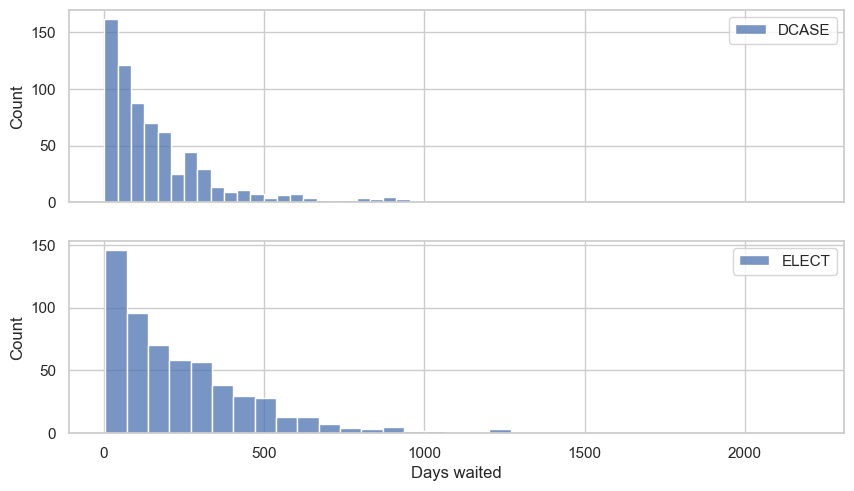

In [13]:
fig, ax = plt.subplots(2,1, sharex=True)

fig.set_figheight(5.5)
fig.set_figwidth(10)

for a, (urgency, wait_list_df) in zip(ax, tno_wait_list_df.groupby("em_el_dc")):
    label = urgency if urgency != "Inpatient" else "ELECT"
    sns.histplot(wait_list_df["hours_waited"] / 24, label=label, ax=a)

    a.legend()
plt.xlabel("Days waited")

plt.savefig("images/wait_times.png", dpi=600)

In [171]:
len(wait_list_df[(wait_list_df["hours_waited"] / 24) >1500])

4

In [170]:
tno_wait_list_df[["hours_waited", "em_el_dc"]].to_csv("data/wait_list.csv", index=False)

### Surgery duration

In [15]:
with engine.connect() as conn:
    tno_theatre_list_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\2201337694.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_list_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit.sql").read(), con=conn.connection)


In [16]:
tno_theatre_list_df["SchDur"] = pd.to_numeric(tno_theatre_list_df["SchDur"])

AdmissionType    0
SchDur           0
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

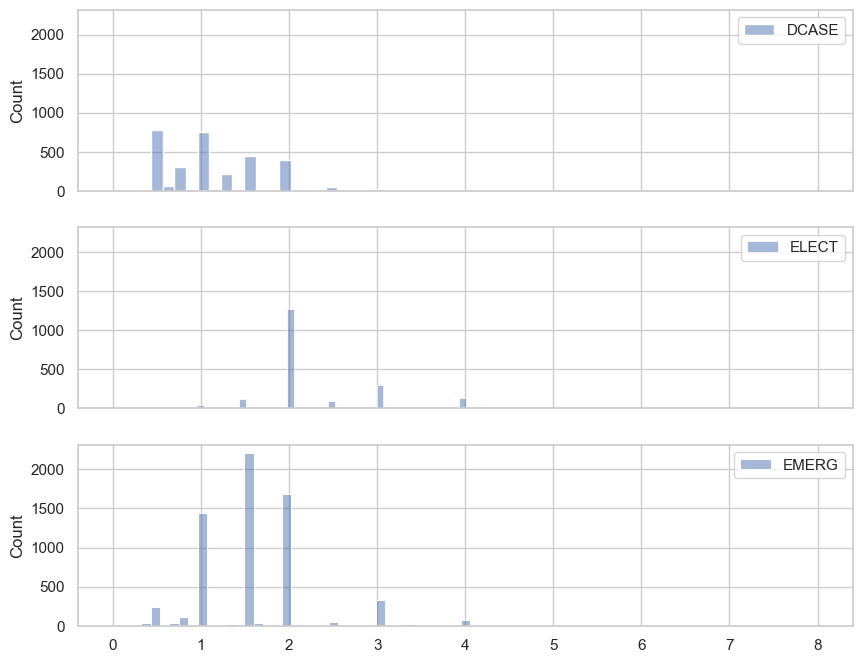

In [17]:
display(tno_theatre_list_df[["AdmissionType", "SchDur"]].isna().sum())

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)

theatre_dur_dict = {}

for ax, (admission_type, schdur) in zip(axs, tno_theatre_list_df[["AdmissionType", "SchDur"]].dropna().groupby("AdmissionType")):
    schdur["SchDur"] = schdur["SchDur"] / 60
    theatre_dur_dict[admission_type] = np.histogram(schdur["SchDur"].values, bins = range(0, int(schdur["SchDur"].max())+1), density=True)
    sns.histplot(schdur, ax=ax, label=admission_type)
    ax.legend()

<Axes: xlabel='SchSurgeryDate'>

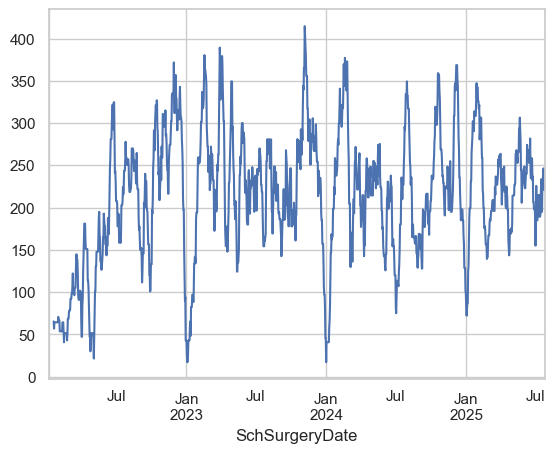

In [18]:
tno_theatre_list_df["SchSurgeryDate"] = pd.to_datetime(tno_theatre_list_df["SchSurgeryDate"])
tno_theatre_list_df.query("em_el_dc == 'ELECT'").set_index("SchSurgeryDate").resample('d')["SchDur"].sum().rolling(14).mean().plot()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

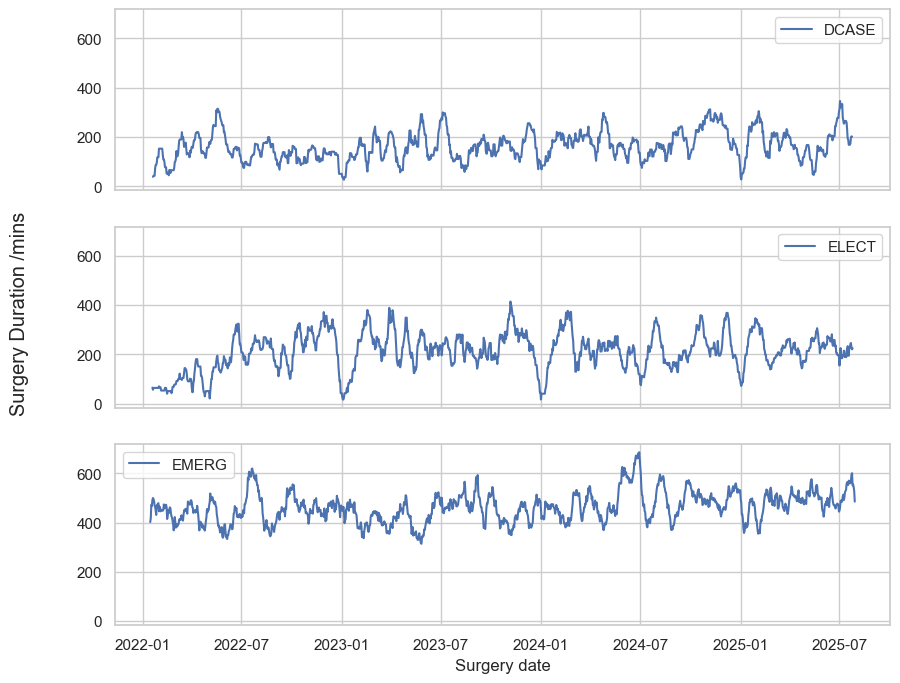

In [19]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)

for a,urgency in zip(axs, ["DCASE", "ELECT", "EMERG"]):
    sns.lineplot(tno_theatre_list_df.query(f"em_el_dc == '{urgency}'").set_index("SchSurgeryDate").resample('d')["SchDur"].sum().rolling(14).mean().dropna(), ax=a, label=urgency)
    a.set_ylabel('')

fig.supylabel("Surgery Duration /mins")
plt.xlabel("Surgery date")

plt.savefig("images/surgery_duration.png", dpi=600)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\4176852299.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_list_more_recent_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit_more_recent.sql").read(), con=conn.connection)


AdmissionType    0
SchDur           0
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

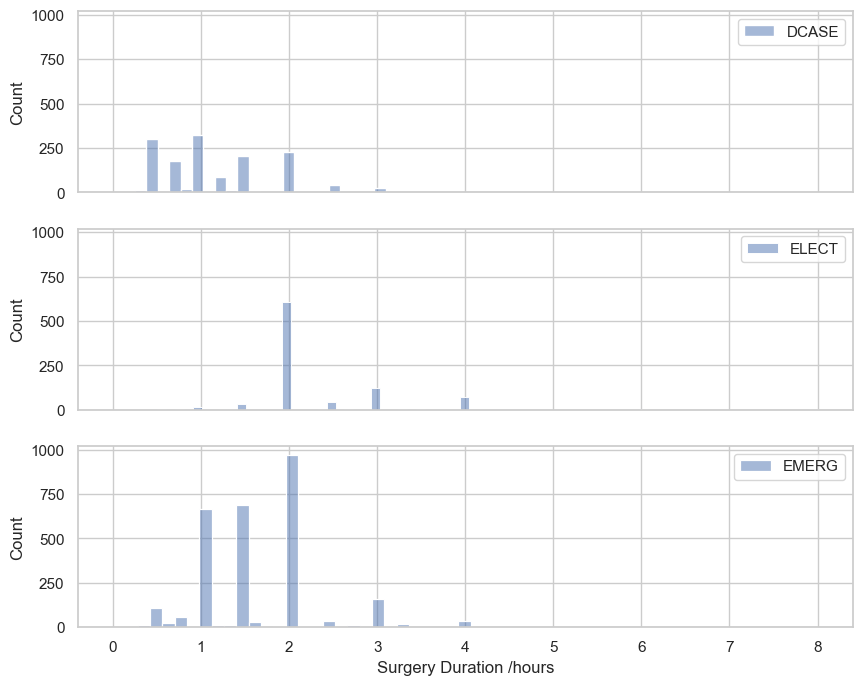

In [20]:
with engine.connect() as conn:
    tno_theatre_list_more_recent_df = pd.read_sql(open("SQL_queries\\tno_surgery_durations_LR_edit_more_recent.sql").read(), con=conn.connection)

tno_theatre_list_more_recent_df["SchDur"] = pd.to_numeric(tno_theatre_list_more_recent_df["SchDur"])

display(tno_theatre_list_more_recent_df[["AdmissionType", "SchDur"]].isna().sum())

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)

theatre_dur_dict = {}

for ax, (admission_type, schdur) in zip(axs, tno_theatre_list_more_recent_df[["AdmissionType", "SchDur"]].dropna().groupby("AdmissionType")):
    schdur["SchDur"] = schdur["SchDur"] / 60
    # theatre_dur_dict[admission_type] = np.histogram(schdur["SchDur"].values, bins = range(0, int(schdur["SchDur"].max())+1), density=True)
    theatre_dur_dict[admission_type] = np.histogram(schdur["SchDur"].values, density=True, bins=20)
    # theatre_dur_dict[admission_type][1][0] += 0.0001
    sns.histplot(schdur, ax=ax, label=admission_type)
    ax.legend()

plt.xlabel("Surgery Duration /hours")

plt.savefig("images/surgery_duration_hist.png", dpi=600)

In [172]:
with open("data/surgery_durations.json", 'w') as fout:
    json.dump({k:(v[0].tolist(), v[1].tolist()) for k,v in theatre_dur_dict.items()}, fout, indent=4)

### LoS

AdmissionType     0
LoS              37
dtype: int64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

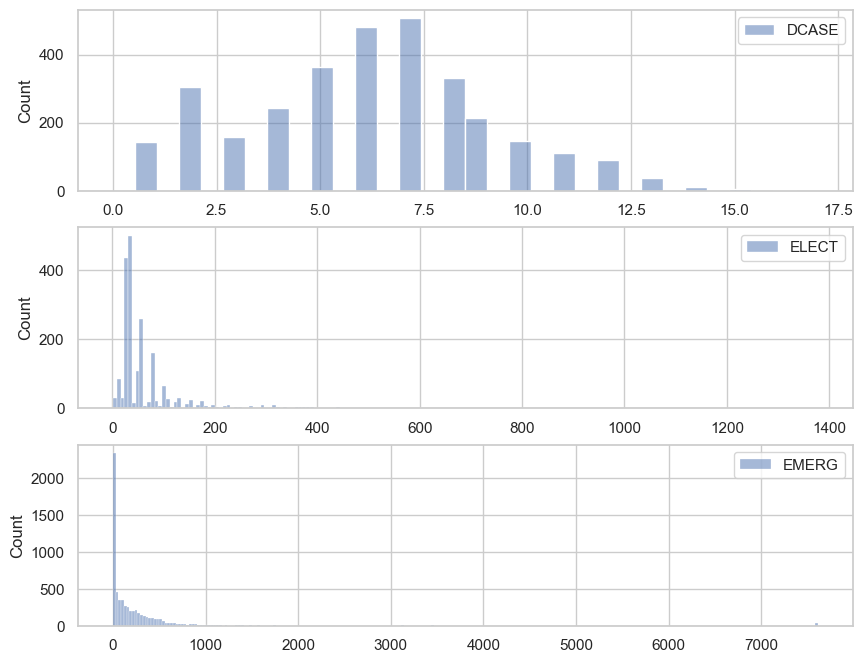

In [21]:
display(tno_theatre_list_df[["AdmissionType", "LoS"]].isna().sum())

tno_theatre_list_df["LoS"] = tno_theatre_list_df["LoS"].fillna(tno_theatre_list_df["LoS"].max())

fig, axs = plt.subplots(3, 1)
fig.set_figheight(8)
fig.set_figwidth(10)

los_dict = {}

for ax, (admission_type, schdur) in zip(axs, tno_theatre_list_df[["AdmissionType", "LoS"]].dropna().groupby("AdmissionType")):
    los_dict[admission_type] = np.histogram(schdur["LoS"].values, bins = range(0, int(schdur["LoS"].max())+1), density=True)
    sns.histplot(schdur, ax=ax, label=admission_type)
    ax.legend()

In [189]:
tno_theatre_list_df.isna().sum()

SchSurgeryDate                  0
SchSurgeryTime                  0
SchDur                          0
SurgSpecialty                 766
TreatmentFunctionCode           0
em_el_dc                       78
ReferralDate                 1828
AdmissionType                   0
TheatreDuration               141
RecoveryTimes                2398
StartDate                       0
EndDate                     11557
TheatreSessionType              0
Session Planned End Time        0
PlannedStartTime                0
PlannedEndTime                  0
LoS                             0
SchSurgeryDateTime              0
dtype: int64

In [173]:
with open("data/los.json", 'w') as fout:
    json.dump({k:(v[0].tolist(), v[1].tolist()) for k,v in los_dict.items()}, fout, indent=4)

In [22]:
tno_theatre_list_df["LoS"].fillna(tno_theatre_list_df["LoS"].max())

0        1042.0
1         969.0
2          10.0
3          65.0
4         262.0
          ...  
11552    7608.0
11553       4.0
11554       8.0
11555    7608.0
11556    7608.0
Name: LoS, Length: 11557, dtype: float64

<Axes: xlabel='SchSurgeryDate'>

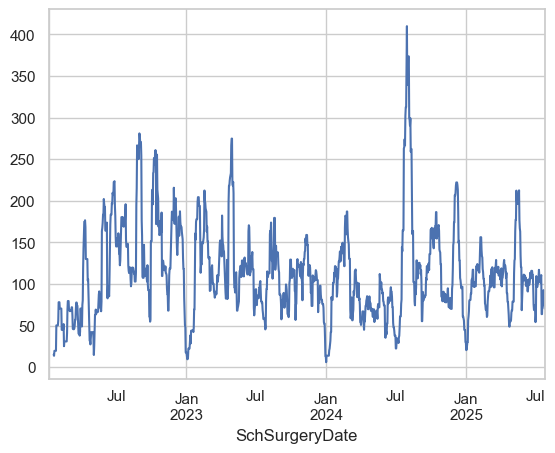

In [23]:
tno_theatre_list_df.query("em_el_dc == 'ELECT'").set_index("SchSurgeryDate").resample('d')["LoS"].sum().rolling(14).mean().plot()

<Axes: xlabel='SchSurgeryDate'>

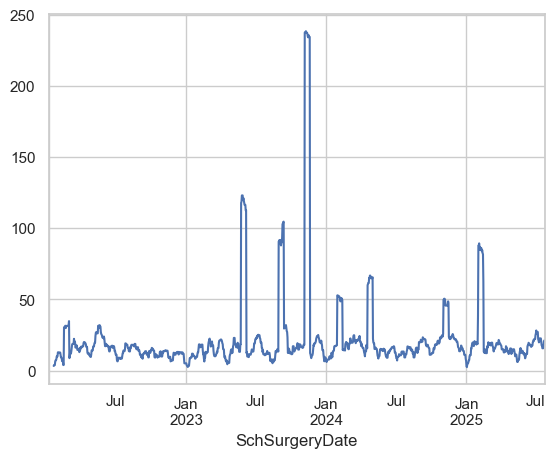

In [24]:
tno_theatre_list_df.query("em_el_dc == 'DCASE'").set_index("SchSurgeryDate").resample('d')["LoS"].sum().rolling(14).mean().plot()

<Axes: xlabel='SchSurgeryDate'>

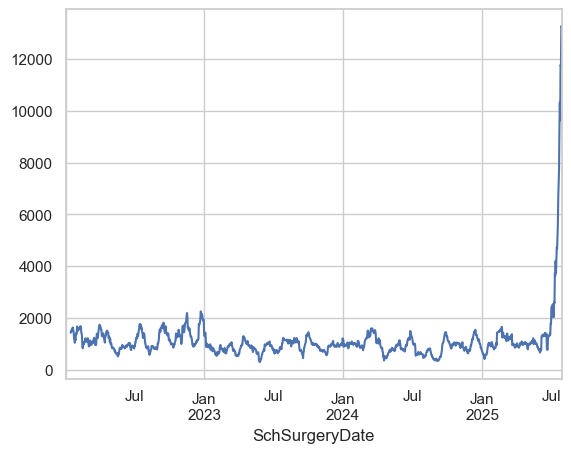

In [25]:
(tno_theatre_list_df.query("em_el_dc == 'EMERG'").set_index("SchSurgeryDate").resample('d')["LoS"].sum()).rolling(14).mean().plot()

In [26]:
with engine.connect() as conn:
    tno_remaining_los_df = pd.read_sql(open("SQL_queries\\tno_remaining_los.sql").read(), con=conn.connection)

tno_remaining_los_df

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\2647820903.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_remaining_los_df = pd.read_sql(open("SQL_queries\\tno_remaining_los.sql").read(), con=conn.connection)


,censusdatetime,em_el_dc,Remaining_los
0,2022-01-12,EMERG,4392.0
1,2022-01-13,EMERG,4368.0
2,2022-01-14,EMERG,4344.0
3,2022-01-15,EMERG,4320.0
4,2022-01-16,EMERG,4296.0
...,...,...,...
71791,2025-07-30,EMERG,NaN
71792,2025-07-30,EMERG,NaN
71793,2025-07-30,EMERG,NaN
71794,2025-07-30,EMERG,NaN


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


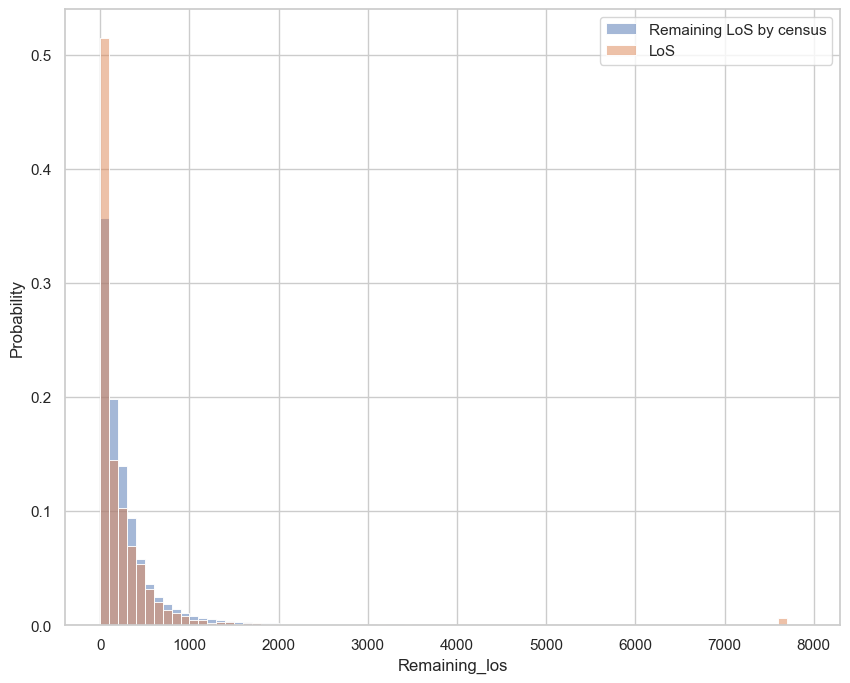

In [27]:
fig = plt.figure(figsize=(10, 8))

ax = sns.histplot(tno_remaining_los_df.dropna()["Remaining_los"], bins=range(0,8000,100), alpha=0.5, stat='probability', label="Remaining LoS by census")
sns.histplot(schdur["LoS"], bins=range(0,8000,100), alpha=0.5, stat='probability', label="LoS", ax=ax)

plt.legend()

In [28]:
tno_remaining_los_df[(tno_remaining_los_df["Remaining_los"] < 0)]

,censusdatetime,em_el_dc,Remaining_los
20283,2023-01-16,EMERG,-4.0
20341,2023-01-17,EMERG,-28.0
20414,2023-01-18,EMERG,-52.0
20492,2023-01-19,EMERG,-76.0
20512,2023-01-20,EMERG,-100.0
20566,2023-01-21,EMERG,-124.0
20632,2023-01-22,EMERG,-148.0
20686,2023-01-23,EMERG,-172.0
20759,2023-01-24,EMERG,-196.0
20838,2023-01-25,EMERG,-220.0


In [177]:
remaining_los = np.histogram(tno_remaining_los_df.dropna()["Remaining_los"],density=True, bins=range(0, int(tno_remaining_los_df["Remaining_los"].max())+1))
with open("data/remaining_los.json", 'w') as fout:
    json.dump((remaining_los[0].tolist(), remaining_los[1].tolist()), fout, indent=4)

In [30]:
tno_remaining_los_df.isna().sum()

censusdatetime      0
em_el_dc            0
Remaining_los     647
dtype: int64

### Theatre Slots

In [31]:
with engine.connect() as conn:
    tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\413890781.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tno_theatre_slots_df = pd.read_sql(open("SQL_queries\\tno_theatre_slots_LR_edit.sql").read(), con=conn.connection) # This list is up-to-date


In [32]:
tno_theatre_slots_df["SchDur"] = pd.to_numeric(tno_theatre_slots_df["SchDur"])

In [33]:
tno_theatre_slots_df["em_el_dc"] = tno_theatre_slots_df["em_el_dc"].fillna("EMERG")

In [34]:
def generate_schedule():
    min_date = tno_theatre_slots_df["SchSurgeryDate"].min()
    em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}   

    schedule = []

    for date_room, theatre_slot_df in tno_theatre_slots_df.groupby(["SchSurgeryDate", "SchOperatingRoom"]):
        hours_remaining = theatre_slot_df["SchDur"].sum() / 60
        patient_type = em_el_dc_mapping[theatre_slot_df["em_el_dc"].mode()[0]]
        hour = ((date_room[0] - min_date) + pd.Timedelta(f"{theatre_slot_df['SchSurgeryTime'].min()}:00")) / pd.Timedelta(hours=1)
        schedule.append((hour, patient_type, hours_remaining, hours_remaining, []))

    return pd.DataFrame(schedule.copy(), columns=["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")

In [35]:
import itertools

sim_day_1 = pd.to_datetime("01/03/25", dayfirst=True)

with engine.connect() as conn:
    theatre_df = pd.read_sql(open("SQL_queries\Theatre draft 2.1_cs_edit.sql").read(), con=conn.connection)

def create_schedule(theatre_df):

    theatre_df["SchDur"] = pd.to_numeric(theatre_df["SchDur"])

    theatre_df = theatre_df[["SchOperatingRoom", "SchSurgeryDate", "SchSurgeryDateTime", "SchDur", "LoS", "em_el_dc", "ReferralDate"]]

    theatre_df["LoS"] = theatre_df["LoS"].fillna(theatre_df["LoS"].max())
    theatre_df["ReferralDate"] = theatre_df["ReferralDate"].fillna(theatre_df["SchSurgeryDate"])

    hours_remaining = 0
    schedule = []
    
    em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}

    for schdateroom, schdf in theatre_df.groupby(["SchOperatingRoom", "SchSurgeryDate"]):

        sorted_df = schdf.sort_values(by=["SchSurgeryDateTime"])

        hour = int(round((sorted_df["SchSurgeryDateTime"].iloc[0] - sim_day_1) / pd.Timedelta(hours=1)))
        hours_total = (sorted_df["SchSurgeryDateTime"].iloc[-1] + pd.Timedelta(minutes=sorted_df["SchDur"].iloc[-1]) - sorted_df["SchSurgeryDateTime"].iloc[0]) / pd.Timedelta(hours=1)
        patients = []

        patient_type = em_el_dc_mapping[schdf["em_el_dc"].mode()[0]]

        schedule.append([hour, patient_type, hours_total, hours_total, patients])


    schedule = pd.DataFrame(schedule, columns = ["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")
    schedule = schedule[schedule["hour"] <= 14*24]

    return schedule

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\129478036.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  theatre_df = pd.read_sql(open("SQL_queries\Theatre draft 2.1_cs_edit.sql").read(), con=conn.connection)


In [182]:
create_schedule(theatre_df).to_csv("data/theatre_schedule.csv", index=False)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\129478036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatre_df["LoS"] = theatre_df["LoS"].fillna(theatre_df["LoS"].max())
C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\129478036.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theatre_df["ReferralDate"] = theatre_df["ReferralDate"].fillna(theatre_df["SchSurgeryDate"])


In [36]:
with engine.connect() as conn:
    occupancy_home_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy_source_home.sql").read(), con=conn.connection)

occupancy_home_df["sim_time"] = (occupancy_home_df['dst'] - sim_day_1) / pd.Timedelta(hours=1)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\3396286057.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occupancy_home_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy_source_home.sql").read(), con=conn.connection)


In [181]:
occupancy_home_df[["occupancy", "sim_time"]].to_csv("data/occupancy.csv", index=False)

In [37]:
# TODO:
#  Verify delay between referral and appointments (look at the probability distribution)
#  Include some prioritisation within the scheduling
#  Examine wait times for appointments (+ increased capacity etc...) -- Use for validation too

#  Look at ratios of priorities, then book in based on closest to priority threshold? -- Look at wait list prioritisation

In [38]:
# Get the sim running with parameterisation
# Run ensembles
# Create the analysis code...

## Running the Sim

In [39]:
import itertools
from surgical_sim import Patient
from sim_tools.distributions import GroupedContinuousEmpirical, DiscreteEmpirical


SEED = 42

EMERGENCY_MEAN_IAT = 10
EMERGENCY_SURGICAL_DURATION = 3
EMERGENCY_MEAN_RECOVERY_TIME = 60

ELECTIVE_MEAN_IAT = 16
ELECTIVE_SURGICAL_DURATION = 2
ELECTIVE_MEAN_RECOVERY_TIME = 48

RUN_LENGTH = 480
NUM_BEDS = 10
NUM_CC_BEDS = 2

DAILY = 24
WEEKLY = 7 * DAILY

INITIAL_NUMBER_OF_ELECTIVE = 3
INITIAL_NUMBER_OF_EMERGENCY = 1

MAX_EMERGENCY_WAIT = 48


class Experiment:
    def __init__(
        self,
        iat_dict,
        theatre_dur_dict,
        los_dict,
        remaining_los,
        seed=SEED,
        initial_number_of_elective=INITIAL_NUMBER_OF_ELECTIVE,
        initial_number_of_emergency=INITIAL_NUMBER_OF_EMERGENCY,
        max_emergency_wait=MAX_EMERGENCY_WAIT,
    ):
        self.patients = []

        self.initial_number_of_elective = initial_number_of_elective
        self.initial_number_of_emergency = initial_number_of_emergency

        seeds = np.random.SeedSequence(seed).spawn(10)

        self.emergency_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["EMERG"][1][:-1],
            upper_bounds = iat_dict["EMERG"][1][1:],
            freq = iat_dict["EMERG"][0],
            random_seed = seeds[0]
        )

        self.elective_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["ELECT"][1][:-1],
            upper_bounds = iat_dict["ELECT"][1][1:],
            freq = iat_dict["ELECT"][0],
            random_seed = seeds[1]
        )

        self.dcase_arrival_dist = GroupedContinuousEmpirical(
            lower_bounds = iat_dict["DCASE"][1][:-1],
            upper_bounds = iat_dict["DCASE"][1][1:],
            freq = iat_dict["DCASE"][0],
            random_seed = seeds[2]
        )

        mask = np.where(theatre_dur_dict["EMERG"][0] > 0)
        self.emergency_surgical_duration_dist = DiscreteEmpirical(
            # theatre_dur_dict["EMERG"][1][:-1][mask],
            ((theatre_dur_dict["EMERG"][1][:-1] + theatre_dur_dict["EMERG"][1][1:]) /2)[mask],
            theatre_dur_dict["EMERG"][0][mask],
            random_seed = seeds[3]
        )

        mask = np.where(theatre_dur_dict["ELECT"][0] > 0)
        self.elective_surgical_duration_dist = DiscreteEmpirical(
            # theatre_dur_dict["ELECT"][1][:-1][mask],
            ((theatre_dur_dict["ELECT"][1][:-1] + theatre_dur_dict["ELECT"][1][1:]) /2)[mask],
            theatre_dur_dict["ELECT"][0][mask],
            random_seed = seeds[4]
        )

        mask = np.where(theatre_dur_dict["DCASE"][0] > 0)
        self.dcase_surgical_duration_dist = DiscreteEmpirical(
            # theatre_dur_dict["DCASE"][1][:-1][mask],
            ((theatre_dur_dict["DCASE"][1][:-1] + theatre_dur_dict["DCASE"][1][1:]) /2)[mask],
            theatre_dur_dict["DCASE"][0][mask],
            random_seed = seeds[5]
        )

        self.emergency_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["EMERG"][1][:-1],
            upper_bounds = los_dict["EMERG"][1][1:],
            freq = los_dict["EMERG"][0],
            random_seed = seeds[6]
        )

        self.elective_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["ELECT"][1][:-1],
            upper_bounds = los_dict["ELECT"][1][1:],
            freq = los_dict["ELECT"][0],
            random_seed = seeds[7]
        )

        self.dcase_recovery_time_dist = GroupedContinuousEmpirical(
            lower_bounds = los_dict["DCASE"][1][:-1],
            upper_bounds = los_dict["DCASE"][1][1:],
            freq = los_dict["DCASE"][0],
            random_seed = seeds[8]
        )

        self.remaining_los_dist = GroupedContinuousEmpirical(
            lower_bounds = remaining_los[1][:-1],
            upper_bounds = remaining_los[1][1:],
            freq = remaining_los[0],
            random_seed = seeds[9]
        )

        self.max_emergency_wait = max_emergency_wait


class PatientGenerator:
    def __init__(self, arrival_dist, surgical_duration_dist, recovery_time_dist, patient_prefix):
        self.arrival_dist = arrival_dist
        self.surgical_duration_dist = surgical_duration_dist
        self.recovery_time_dist = recovery_time_dist
        self.prefix = patient_prefix
        
    def generate_patient(self, env, experiment, schedule):
        for patient_count in itertools.count(start=1):
            inter_arrival_time = self.arrival_dist.sample()

            yield env.timeout(inter_arrival_time)

            p = Patient(
                f"{self.prefix}{patient_count}",
                arrival_time=env.now,
                surgery_duration=self.surgical_duration_dist.sample(),
                recovery_time=self.recovery_time_dist.sample(),
            )
            experiment.patients.append(p)

            logging.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)

    def initial_generate_patient(self, env, experiment, schedule, wait_list):
        patient_count = -1
        for _, row in wait_list.iterrows():
            p = Patient(
                f"{self.prefix}{patient_count}", 
                arrival_time=-row["hours_waited"], 
                surgery_duration=self.surgical_duration_dist.sample(), 
                recovery_time=self.recovery_time_dist.sample()
            )

            experiment.patients.append(p)
            logger.info(f"{env.now:.2f}: {p.id} referral arrives.")

            schedule.schedule_patients([p], env.now)
            

            patient_count -= 1


In [40]:
# from surgical_sim import Schedule, setup_logger
# import simpy

# env = simpy.Environment()

# logger = setup_logger(env)

# experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, seed=42)

# s = Schedule([])

# schedule_df = create_schedule(theatre_df)

# s.processed_schedule = schedule_df
# s._Schedule__schedule = {
#     hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
#     for hour, data in schedule_df.groupby("hour")
# }

# pg = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")

# emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=50), columns=["hours_waited"])
# emerg_wait_list = emerg_wait_list.sort_values(by="hours_waited", ascending=False)

# pg.initial_generate_patient(env, experiment, s, emerg_wait_list)

In [41]:
# s.processed_schedule

In [42]:
import logging
from surgical_sim import daily_planning, scheduler, Schedule, setup_logger
import simpy
from collections import defaultdict

NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

schedule_df = generate_schedule()

s.processed_schedule = schedule_df
s._Schedule__schedule = {
    hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
    for hour, data in schedule_df.groupby("hour")
}

experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=42)

emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency").generate_patient
elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective").generate_patient
dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase").generate_patient

metrics = defaultdict(lambda : [])
env = simpy.Environment()

logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

env.process(emergency_patient_generator(env, experiment, s))
env.process(elective_patient_generator(env, experiment, s))
env.process(dcase_patient_generator(env, experiment, s))
env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)

INFO - 0.00 - New day!!!
INFO - 0.00 - 0 beds used, []
INFO - 0.00 - 0 patients are breaching! []
INFO - 2.64 - 2.64: Daycase1 referral arrives.
INFO - 2.64 - Scheduling Daycase1 for 62.0
INFO - 12.02 - 12.02: Elective1 referral arrives.
INFO - 12.02 - Scheduling Elective1 for 33.0
INFO - 16.40 - 16.40: Elective2 referral arrives.
INFO - 16.40 - Scheduling Elective2 for 58.0
INFO - 16.77 - 16.77: Daycase2 referral arrives.
INFO - 16.77 - Scheduling Daycase2 for 62.0
INFO - 19.42 - 19.42: Daycase3 referral arrives.
INFO - 19.42 - Scheduling Daycase3 for 62.0
INFO - 24.00 - New day!!!
INFO - 24.00 - 0 beds used, []
INFO - 24.00 - 0 patients are breaching! []
INFO - 24.36 - 24.36: Emergency1 referral arrives.
INFO - 24.36 - Scheduling Emergency1 for 33.0
INFO - 25.76 - 25.76: Daycase4 referral arrives.
INFO - 25.76 - Scheduling Daycase4 for 62.0
INFO - 28.99 - 28.99: Elective3 referral arrives.
INFO - 28.99 - Scheduling Elective3 for 33.0
INFO - 33.00 - Sending Elective: [Patient(id='Elec

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'Occupied Beds')

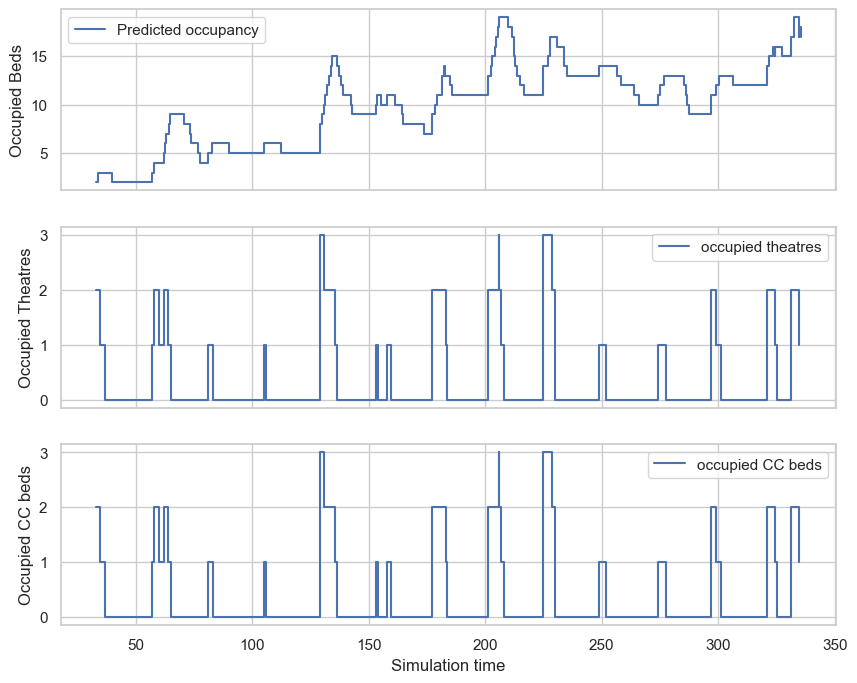

In [43]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


metrics["surgical_event"].sort(key=lambda e: (e[0], e[1]))

surgical_event = np.array(metrics["surgical_event"])
surgeries = surgical_event[:, 1].cumsum()
df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied theatres"]).drop_duplicates(subset="Simulation time", keep='last')

metrics["cc_bed_event"].sort(key=lambda e: (e[0], e[1]))

cc_bed_events = np.array(metrics["cc_bed_event"])
cc_beds = cc_bed_events[:, 1].cumsum()
df_cc_beds = pd.DataFrame(np.hstack([cc_bed_events, cc_beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied CC beds"]).drop_duplicates(subset="Simulation time", keep='last')


fig, ax = plt.subplots(3,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)

sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy", ax=ax[0])
# sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Occupied Beds")

sns.lineplot(df_surgery, x="Simulation time", y="Occupied theatres", drawstyle='steps-post', label="occupied theatres", ax=ax[1])
ax[1].set_xlabel("Simulation Time")
ax[1].set_ylabel("Occupied Theatres")

sns.lineplot(df_cc_beds, x="Simulation time", y="Occupied CC beds", drawstyle='steps-post', label="occupied CC beds", ax=ax[2])
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Occupied Beds")

In [44]:
import logging
from surgical_sim import daily_planning, scheduler, Schedule, setup_logger
import simpy
from collections import defaultdict

NUM_BEDS = 100
NUM_CC_BEDS = 16

def single_run(run_id=1, seed=42):
    print(seed)

    s = Schedule([])

    # schedule_df = generate_schedule()
    schedule_df = create_schedule(theatre_df)

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.ERROR)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "ELECT"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    return metrics


In [45]:
from joblib import Parallel, delayed    

def parallel_run(num_cores=-1, num_runs=1, seed=42):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0]) for i in range(num_runs)
    )
    return results

res = parallel_run(num_runs=10)

In [46]:
beds_ensemble = []
surgeries_ensemble = []

for i, r in enumerate(res):
    r["bed_event"].sort(key=lambda e: (e[0], e[1]))
    bed_events = np.array(r["bed_event"])

    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied beds {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    beds_ensemble.append(df_beds.drop("Change", axis=1))


    r["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(r["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied theatres {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    surgeries_ensemble.append(df_surgery.drop("Change", axis=1))


C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\1452475326.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na op

Text(0.5, 0, 'Simulation time /hours')

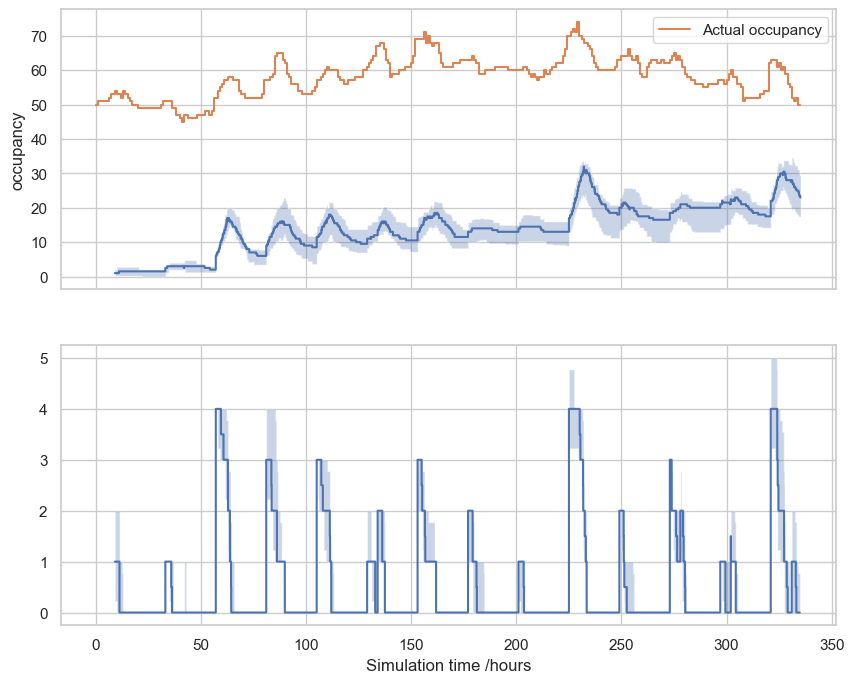

In [47]:
from functools import reduce

fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)


merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)

sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[0], drawstyle='steps-post')
sns.lineplot(occupancy_home_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)


merged_surgery_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), surgeries_ensemble).fillna(method='ffill').fillna(0)
sns.lineplot(x=merged_surgery_df["Simulation time"], y=np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[1], drawstyle='steps-post')
ax[1].fill_between(
    merged_surgery_df["Simulation time"], 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.xlabel("Simulation time /hours")

## Scenario 2: Initial occupancy

In [183]:
with engine.connect() as conn:
    init_occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_initial_occupancy.sql").read(), con=conn.connection)

init_occupancy_df = init_occupancy_df.fillna(init_occupancy_df.max()) # Gaps are current inpatients
init_occupancy_df.to_csv("data/initial_occupancy.csv", index=False)

def bed_preload(env, beds, remaining_los, metrics):
    with beds.request() as bed_req:
        yield bed_req
        metrics["bed_event"].append((env.now, 1))
        yield env.timeout(remaining_los)
        metrics["bed_event"].append((env.now, -1))

def initialise_ward(env, beds, init_occupancy_df, metrics):
    for remaining_los in init_occupancy_df["Remaining_los"].values:
        env.process(bed_preload(env, beds, remaining_los, metrics))

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\1513386762.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  init_occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_initial_occupancy.sql").read(), con=conn.connection)


In [140]:
# emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=80), columns=["hours_waited"])

# initial_emerg_patients = round(tno_theatre_list_df.query("em_el_dc == 'EMERG'").groupby("SchSurgeryDate").count().resample('W').sum()["SchSurgeryTime"].iloc[1:-1].mean())

initial_emerg_patients = round(tno_theatre_list_more_recent_df.query("em_el_dc == 'EMERG'").groupby("SchSurgeryDate").count().resample('W').sum()["SchSurgeryTime"].iloc[:-1].mean() * 1.5)
print(initial_emerg_patients)

emerg_wait_list = pd.DataFrame(np.random.randint(0, 48, size=initial_emerg_patients), columns=["hours_waited"])
emerg_wait_list = emerg_wait_list.sort_values(by="hours_waited", ascending=False)

52


In [147]:
def single_run(run_id=1, seed=42):
    s = Schedule([])

    # schedule_df = generate_schedule()
    schedule_df = create_schedule(theatre_df)

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed, max_emergency_wait=800)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.ERROR)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initialise_ward(env, beds, init_occupancy_df, metrics)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "Inpatient"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))
    emergency_patient_generator.initial_generate_patient(env, experiment, s, emerg_wait_list) 

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    metrics["patients"] = experiment.patients
    metrics["scheduled"] = s.processed_schedule
    metrics["seed"] = seed

    return metrics


def parallel_run(num_cores=-1, num_runs=1, seed=42):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0]) for i in range(num_runs)
    )
    return results

res = parallel_run(num_runs=1000)

In [148]:
beds_ensemble = []
surgeries_ensemble = []

for i, r in enumerate(res):
    r["bed_event"].sort(key=lambda e: (e[0], e[1]))
    bed_events = np.array(r["bed_event"])

    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied beds {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    beds_ensemble.append(df_beds.drop("Change", axis=1))


    r["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(r["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied theatres {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    surgeries_ensemble.append(df_surgery.drop("Change", axis=1))


C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\1452475326.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na op

Text(0.5, 0, 'Simulation time /hours')

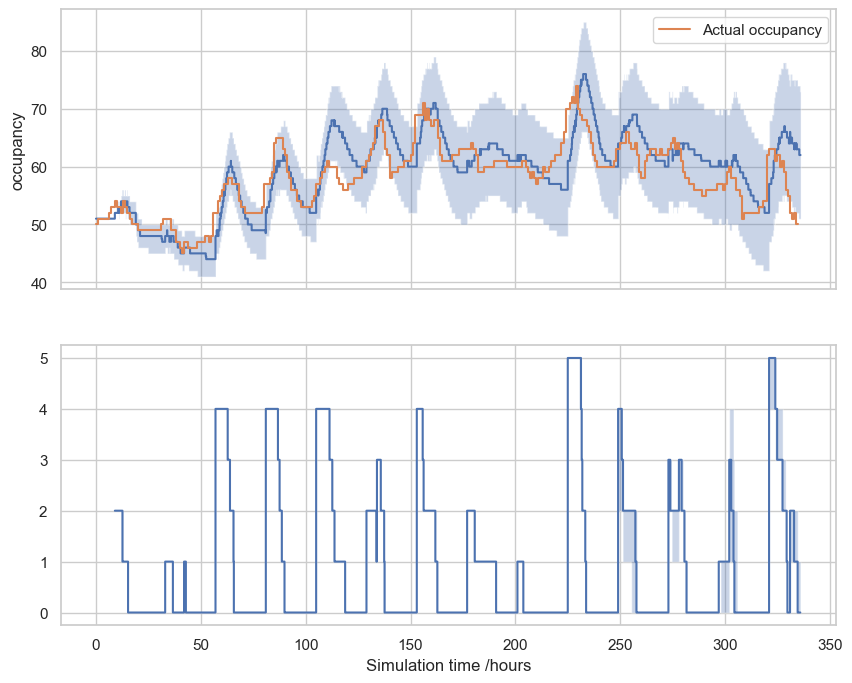

In [149]:
from functools import reduce

fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)


merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)

sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[0], drawstyle='steps-post')
sns.lineplot(occupancy_home_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)


merged_surgery_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), surgeries_ensemble).fillna(method='ffill').fillna(0)
sns.lineplot(x=merged_surgery_df["Simulation time"], y=np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[1], drawstyle='steps-post')
ax[1].fill_between(
    merged_surgery_df["Simulation time"], 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.xlabel("Simulation time /hours")

In [150]:
# TODO:
#  Go through the schedule, numbers of booked patients for each slot, do the same for the theatre_df
#  Try to find where the difference is!!

## Scenario 3: random los initial occupancy

In [151]:
initial_num_occupied_beds = len(init_occupancy_df)

# def bed_preload_random(env, beds, experiment, metrics):
#     with beds.request() as bed_req:
#         yield bed_req
#         metrics["bed_event"].append((env.now, 1))
#         yield env.timeout(experiment.emergency_recovery_time_dist.sample())
#         metrics["bed_event"].append((env.now, -1))

def initialise_ward_random(env, beds, initial_num_occupied_beds, experiment, metrics):
    # for time_remaining in experiment.emergency_recovery_time_dist.sample(initial_num_occupied_beds):
    for time_remaining in experiment.remaining_los_dist.sample(initial_num_occupied_beds):
        env.process(bed_preload(env, beds, time_remaining, metrics))

In [152]:
def single_run(run_id=1, seed=42):
    s = Schedule([])

    # schedule_df = generate_schedule()
    schedule_df = create_schedule(theatre_df)

    s.processed_schedule = schedule_df
    s._Schedule__schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule_df.groupby("hour")
    }

    experiment = Experiment(iat_dict, theatre_dur_dict, los_dict, remaining_los, seed=seed, max_emergency_wait=800)

    emergency_patient_generator = PatientGenerator(experiment.emergency_arrival_dist, experiment.emergency_surgical_duration_dist, experiment.emergency_recovery_time_dist, "Emergency")
    elective_patient_generator = PatientGenerator(experiment.elective_arrival_dist, experiment.elective_surgical_duration_dist, experiment.elective_recovery_time_dist, "Elective")
    dcase_patient_generator = PatientGenerator(experiment.dcase_arrival_dist, experiment.dcase_surgical_duration_dist, experiment.dcase_recovery_time_dist, "Daycase")

    metrics = defaultdict(lambda : [])
    env = simpy.Environment()

    logger = setup_logger(env, logging.INFO)

    beds = simpy.Resource(env, capacity=NUM_BEDS)
    cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

    initialise_ward_random(env, beds, len(init_occupancy_df),experiment, metrics)

    elective_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "Inpatient"'))
    dcase_patient_generator.initial_generate_patient(env, experiment, s, tno_wait_list_df.query('em_el_dc == "DCASE"'))
    emergency_patient_generator.initial_generate_patient(env, experiment, s, emerg_wait_list) 

    env.process(emergency_patient_generator.generate_patient(env, experiment, s))
    env.process(elective_patient_generator.generate_patient(env, experiment, s))
    env.process(dcase_patient_generator.generate_patient(env, experiment, s))
    env.process(daily_planning(env, beds, s, experiment))
    env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

    env.run(until=14*24)

    metrics["patients"] = experiment.patients
    metrics["scheduled"] = s.processed_schedule
    metrics["seed"] = seed

    return metrics


def parallel_run(num_cores=-1, num_runs=1, seed=42):
    seed_spawn = np.random.SeedSequence(seed).spawn(num_runs)
    results = Parallel(n_jobs=num_cores)(
        delayed(single_run)(i, seed_spawn[i].generate_state(1)[0]) for i in range(num_runs)
    )
    return results

res = parallel_run(num_runs=1000)

In [153]:
beds_ensemble = []
surgeries_ensemble = []

for i, r in enumerate(res):
    r["bed_event"].sort(key=lambda e: (e[0], e[1]))
    bed_events = np.array(r["bed_event"])

    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied beds {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    beds_ensemble.append(df_beds.drop("Change", axis=1))


    r["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(r["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", f"Occupied theatres {i}"]).drop_duplicates(subset="Simulation time", keep='last')
    surgeries_ensemble.append(df_surgery.drop("Change", axis=1))


C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_7276\1452475326.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na op

Text(0.5, 0, 'Simulation time /hours')

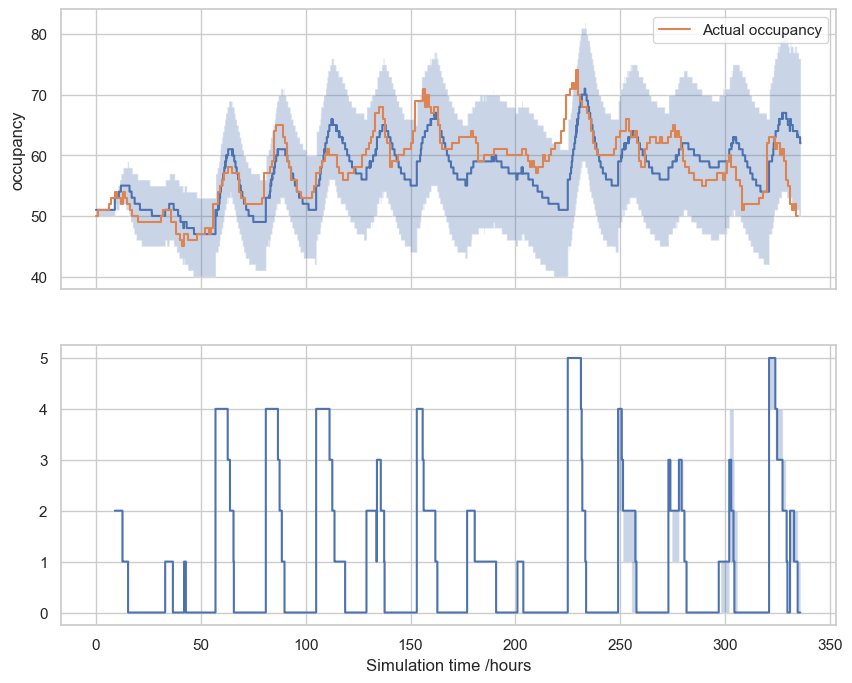

In [154]:
from functools import reduce

fig, ax = plt.subplots(2,1, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)


merged_beds_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), beds_ensemble).fillna(method='ffill').fillna(0)

sns.lineplot(x=merged_beds_df["Simulation time"], y=np.percentile(merged_beds_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[0], drawstyle='steps-post')
sns.lineplot(occupancy_home_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
ax[0].fill_between(
    merged_beds_df["Simulation time"], 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_beds_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)


merged_surgery_df = reduce(lambda left, right: pd.merge(left, right, on='Simulation time', how='outer'), surgeries_ensemble).fillna(method='ffill').fillna(0)
sns.lineplot(x=merged_surgery_df["Simulation time"], y=np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 50, axis=0), ax=ax[1], drawstyle='steps-post')
ax[1].fill_between(
    merged_surgery_df["Simulation time"], 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 2.5, axis=0), 
    np.percentile(merged_surgery_df.set_index("Simulation time").values.T, 97.5, axis=0),
    alpha=0.3,
    step='post'
)

plt.xlabel("Simulation time /hours")

In [155]:
# TODO:
#  Justify the initial emergency patients
#  Save the cached data for all simulation inputs
#  

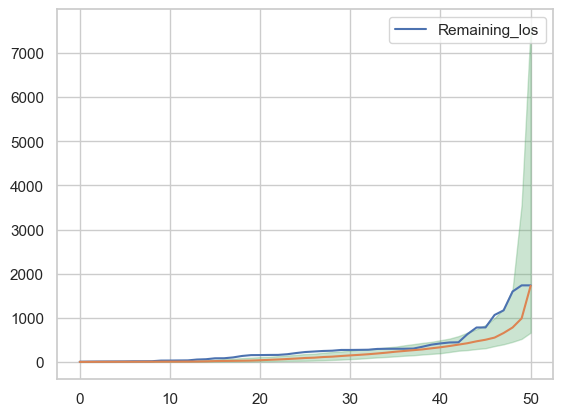

In [58]:
init_occupancy_df.sort_values(by="Remaining_los").reset_index(drop=True).plot()
vals = [sorted(experiment.emergency_recovery_time_dist.sample(initial_num_occupied_beds)) for _ in range(1000)]

plt.plot(np.median(vals, axis=0))

plt.fill_between(range(np.array(vals).shape[1]), np.percentile(vals, 2.5, axis=0), np.percentile(vals, 97.5, axis=0), color='g', alpha=0.3)

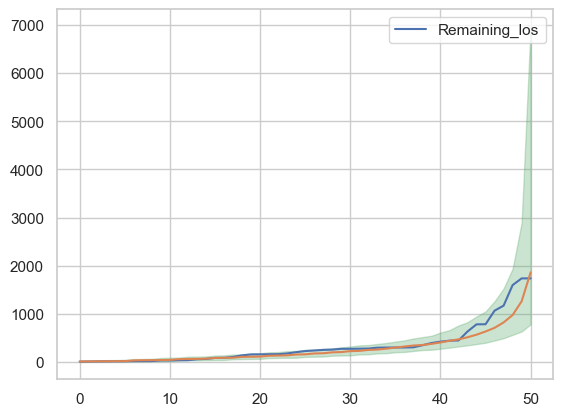

In [59]:
mask = remaining_los[0] > 0
remaining_los_dist = GroupedContinuousEmpirical(
    lower_bounds = remaining_los[1][:-1],
    upper_bounds = remaining_los[1][1:],
    freq = remaining_los[0],
    # random_seed = seeds[6]
)
vals = [sorted(remaining_los_dist.sample(initial_num_occupied_beds)) for _ in range(1000)]

init_occupancy_df.sort_values(by="Remaining_los").reset_index(drop=True).plot()
plt.plot(np.median(vals, axis=0))

plt.fill_between(range(np.array(vals).shape[1]), np.percentile(vals, 2.5, axis=0), np.percentile(vals, 97.5, axis=0), color='g', alpha=0.3)


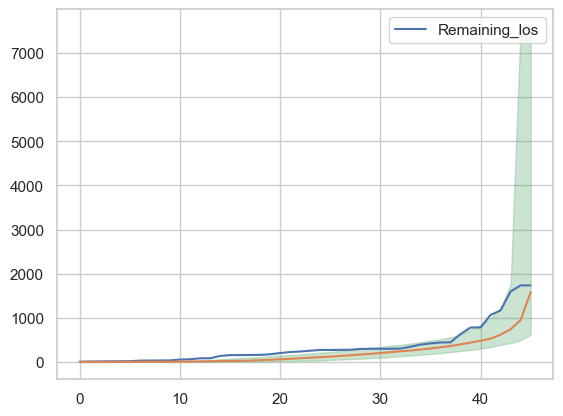

In [60]:
init_occupancy_df.query("em_el_dc == 'EMERG'").sort_values(by="Remaining_los").reset_index(drop=True).plot()

vals = [sorted(experiment.emergency_recovery_time_dist.sample(len(init_occupancy_df.query("em_el_dc == 'EMERG'")))) for _ in range(1000)]

plt.plot(np.median(vals, axis=0))

plt.fill_between(range(np.array(vals).shape[1]), np.percentile(vals, 2.5, axis=0), np.percentile(vals, 97.5, axis=0), color='g', alpha=0.3)

# Maybe examine the remaining los at census points for elective and emerg? It could be that these patients are the longer ones by nature (since the shorter ones would have been discharged already...)

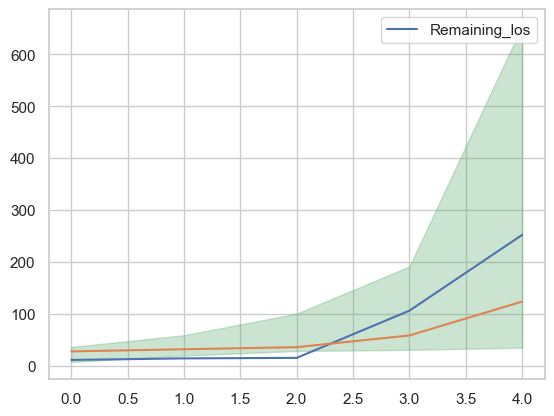

In [61]:
init_occupancy_df.query("em_el_dc == 'ELECT'").sort_values(by="Remaining_los").reset_index(drop=True).plot()

vals = [sorted(experiment.elective_recovery_time_dist.sample(len(init_occupancy_df.query("em_el_dc == 'ELECT'")))) for _ in range(1000)]

plt.plot(np.median(vals, axis=0))

plt.fill_between(range(np.array(vals).shape[1]), np.percentile(vals, 2.5, axis=0), np.percentile(vals, 97.5, axis=0), color='g', alpha=0.3)

(array([[51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [23., 15.,  5.,  1.,  2.,  0.,  2.,  0.,  0.,  3.]]),
 array([   0. ,  173.7,  347.4,  521.1,  694.8,  868.5, 1042.2, 1215.9,
        1389.6, 1563.3, 1737. ]),
 <a list of 2 BarContainer objects>)

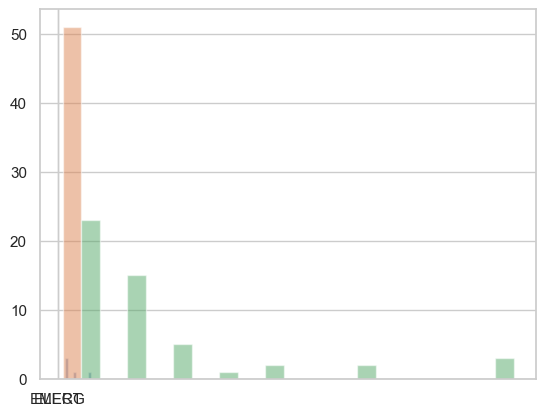

In [62]:
plt.hist(np.median(vals, axis=0), alpha=0.5)

plt.hist(init_occupancy_df, alpha=0.5)

<Axes: ylabel='Frequency'>

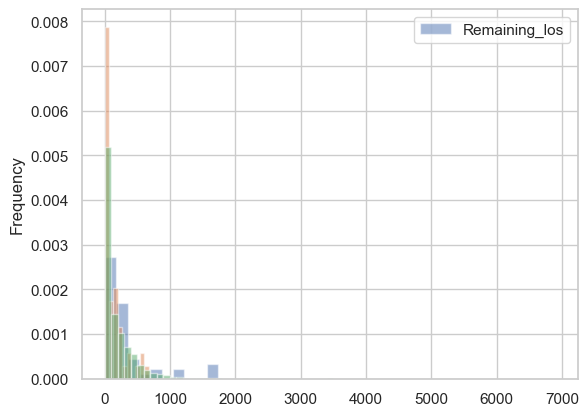

In [63]:
init_occupancy_df.plot.hist(alpha=0.5, density=True)
plt.hist(experiment.emergency_recovery_time_dist.sample(initial_num_occupied_beds), alpha=0.5, density=True)
tno_theatre_list_df.query("em_el_dc == 'EMERG'")["LoS"].plot.hist(bins=range(0, 7000,100), density=True,alpha=0.5)

<Axes: ylabel='Frequency'>

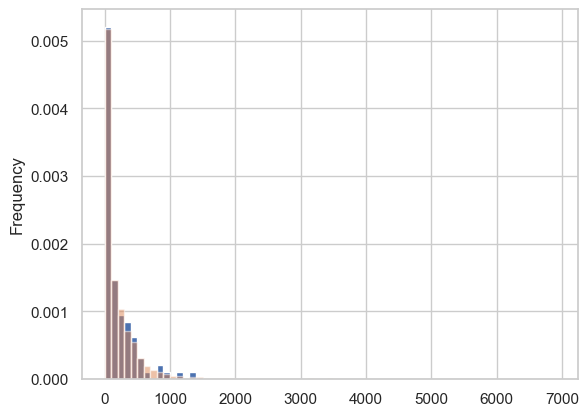

In [64]:
plt.hist([p.recovery_time for p in res[0]["patients"] if p.surgical_time is not None and "Emergency" in p.id], bins=range(0, 7000,100), density=True)
tno_theatre_list_df.query("em_el_dc == 'EMERG'")["LoS"].plot.hist(bins=range(0, 7000,100), density=True,alpha=0.5)

<Axes: ylabel='Frequency'>

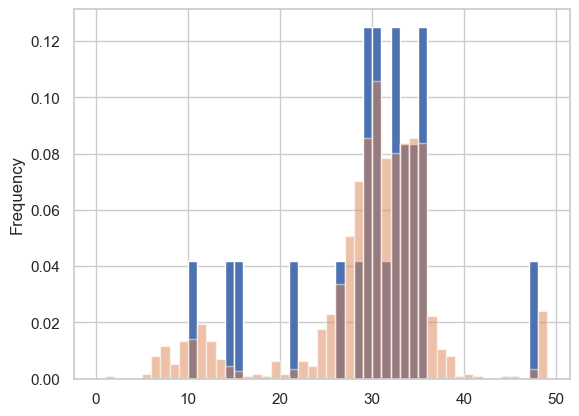

In [65]:
plt.hist([p.recovery_time for p in res[0]["patients"] if p.surgical_time is not None and "Elective" in p.id], density=True, bins=range(0,50))
tno_theatre_list_df.query("em_el_dc == 'ELECT'")["LoS"].plot.hist(density=True,alpha=0.5, bins=range(0,50))

<Axes: ylabel='Frequency'>

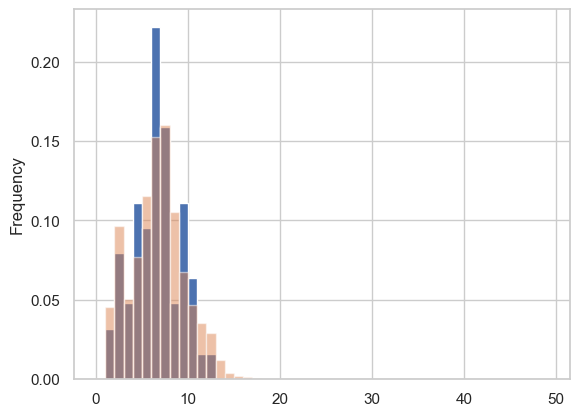

In [66]:
plt.hist([p.recovery_time for p in res[0]["patients"] if p.surgical_time is not None and "Daycase" in p.id], density=True, bins=range(0,50))
tno_theatre_list_df.query("em_el_dc == 'DCASE'")["LoS"].plot.hist(density=True,alpha=0.5, bins=range(0,50))

<BarContainer object of 7608 artists>

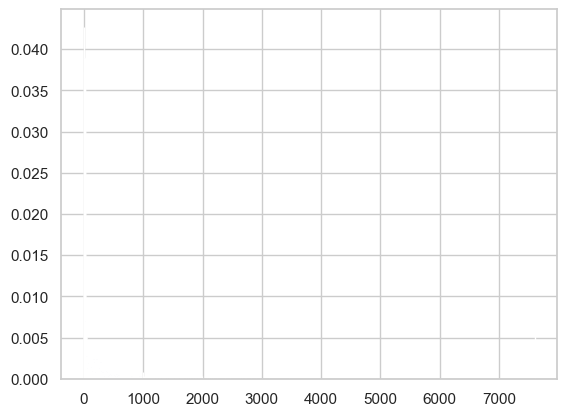

In [67]:
plt.bar(x=los_dict["EMERG"][1][:-1],height=los_dict["EMERG"][0])

<BarContainer object of 1377 artists>

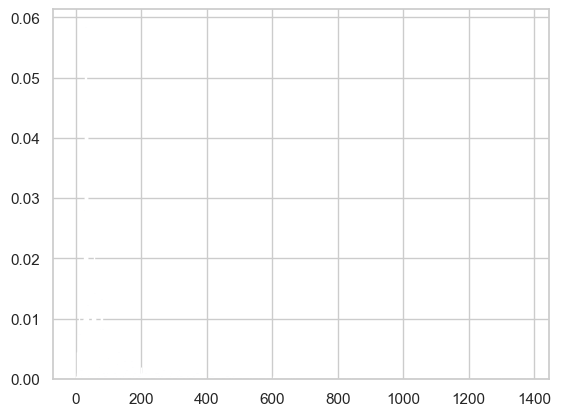

In [68]:
plt.bar(x=los_dict["ELECT"][1][:-1],height=los_dict["ELECT"][0])

<BarContainer object of 17 artists>

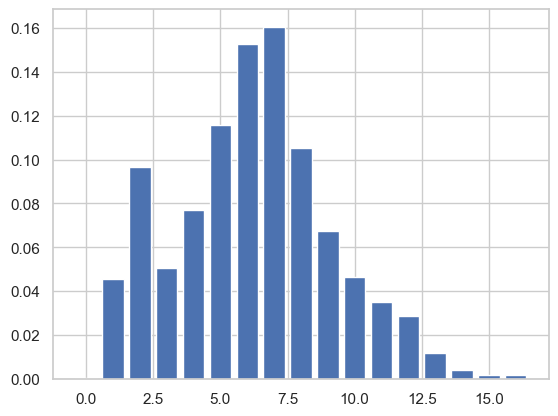

In [69]:
plt.bar(x=los_dict["DCASE"][1][:-1],height=los_dict["DCASE"][0])

<Axes: ylabel='Frequency'>

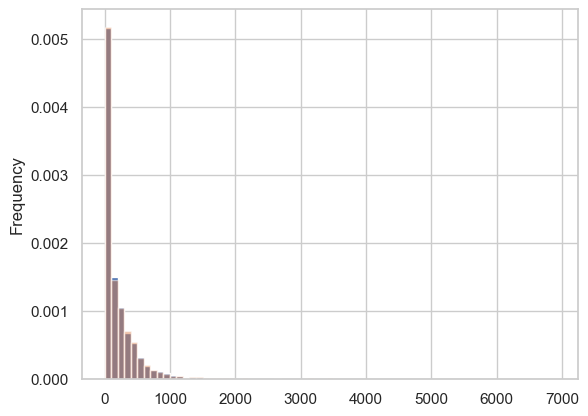

In [70]:
plt.hist(experiment.emergency_recovery_time_dist.sample(10000),bins=range(0, 7000,100), density=True)
tno_theatre_list_df.query("em_el_dc == 'EMERG'")["LoS"].plot.hist(bins=range(0, 7000,100), density=True,alpha=0.5)

In [71]:
tno_theatre_list_df.query("em_el_dc == 'EMERG'")

,SchSurgeryDate,SchSurgeryTime,SchDur,SurgSpecialty,TreatmentFunctionCode,em_el_dc,ReferralDate,AdmissionType,TheatreDuration,RecoveryTimes,StartDate,EndDate,TheatreSessionType,Session Planned End Time,PlannedStartTime,PlannedEndTime,LoS,SchSurgeryDateTime
0,2022-01-02,09:40,60,Trauma & Orthopaedics,110,EMERG,2022-01-02,EMERG,74.0,173.0,2024-03-31,None,Emergency T&O,2022-01-02 18:00,09:00:00,18:00:00,1042.0,2022-01-02 09:40:00
1,2022-01-03,09:00,90,Trauma & Orthopaedics,110,EMERG,2022-01-02,EMERG,49.0,60.0,2024-03-31,None,Emergency T&O,2022-01-03 23:59,00:00:00,23:59:00,969.0,2022-01-03 09:00:00
2,2022-01-03,10:45,60,Trauma & Orthopaedics,110,EMERG,2022-01-03,EMERG,97.0,25.0,2024-03-31,None,Emergency T&O,2022-01-03 23:59,00:00:00,23:59:00,10.0,2022-01-03 10:45:00
3,2022-01-04,09:00,90,Trauma & Orthopaedics,110,EMERG,NaT,EMERG,89.0,39.0,2024-03-31,None,Inpatient,2022-01-04 23:59,00:00:00,23:59:00,65.0,2022-01-04 09:00:00
4,2022-01-04,09:00,90,Trauma & Orthopaedics,110,EMERG,2022-01-03,EMERG,38.0,65.0,2024-03-31,None,Emergency T&O,2022-01-04 18:00,09:00:00,18:00:00,262.0,2022-01-04 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11552,2025-07-28,09:00,90,Trauma & Orthopaedics,110,EMERG,2025-07-27,EMERG,38.0,38.0,2025-07-28,None,Emergency T&O,2025-07-28 18:00,09:00:00,18:00:00,7608.0,2025-07-28 09:00:00
11553,2025-07-28,09:00,60,Trauma & Orthopaedics,110,EMERG,2025-07-28,EMERG,25.0,28.0,2025-07-28,None,Emergency T&O,2025-07-28 13:00,00:00:00,13:00:00,4.0,2025-07-28 09:00:00
11554,2025-07-28,10:00,90,Trauma & Orthopaedics,110,EMERG,2025-07-28,EMERG,31.0,NaN,2025-07-28,None,Emergency T&O,2025-07-28 13:00,00:00:00,13:00:00,8.0,2025-07-28 10:00:00
11555,2025-07-28,14:00,120,Trauma & Orthopaedics,110,EMERG,2025-07-27,EMERG,99.0,33.0,2025-07-28,None,Emergency T&O,2025-07-28 13:00,00:00:00,13:00:00,7608.0,2025-07-28 14:00:00
